# Satellites Characterization
** EE-558, A Network Tour of Data Science ** <br>
** Lucas Gauchoux, Laurier Loiselle, Antoine Weber **

# 0. Abstract

# 1. Imports, global names and helper functions

In [4]:
%matplotlib inline

from helpers import *
import numpy as np
import pandas as pd
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
from numpy import pi
import ephem
from tqdm import tqdm
import reverse_geocoder as rg
from collections import Counter
import networkx as nx
from multiprocessing import Pool
from scipy import sparse, stats, spatial, linalg
from pygsp import graphs, filters, plotting
from mpl_toolkits.basemap import Basemap
import sklearn
import itertools
import matplotlib as mpl
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
def read_tle(tle_file):
    tle = open(tle_file)
    lines = tle.readlines()
    return lines

In [3]:
def compute_tle_informations(lines):
    numb_element = len(lines)
    names = []
    long = []
    lat = []
    elevation_km = []
    for i in range(0,numb_element-1,3):
        temp = ephem.readtle(lines[i], lines[i+1], lines[i+2])
        temp.compute('2017/10/12')
        try:
            long.append(temp.sublong*180/pi)
            lat.append(temp.sublat*180/pi)
            elevation_km.append(temp.elevation/1000)
            names.append(temp.name[2:])
        except:
            print('Index number {} is not compatible to perform computation' .format(i))
    return names,long,lat,elevation_km

In [4]:
def satellite_orbit(name):
    orbit_point = []
    line_1, line_2 = dict_tle[name]
    period = int(sioi[sioi.OBJECT_NAME == name].PERIOD.values[0])
    delta_t = int(period*60/nb_point)
    delta_t = timedelta(seconds = delta_t)
    time = datetime(2017,10,12)
    l1, l2 = dict_tle[name]
    temp = ephem.readtle(name, l1, l2)
    for i in range(0,200):
        time = time + delta_t
        temp.compute(time)
        try:
            lat = temp.sublat*180/pi
            long = temp.sublong*180/pi
            orbit_point.append((lat,long))
        except:
            print("ERROR")
    return orbit_point

In [5]:
def compute_grids(res):
    orbit_grids= []
    vertical_offset =90
    horizontal_offset = 180
    shape = (180,360)
    coverage_width = range(-7, 7)
    for stats in res:
        grid = np.zeros(shape)
        for lat, long in stats:
            lat = round(lat) + vertical_offset
            long = round(long) + horizontal_offset
            for i in coverage_width:
                for j in coverage_width:
                    grid[(lat+i)%shape[0]][(long+j)%shape[1]] = 1
        orbit_grids.append(grid)
    return orbit_grids

In [6]:
def plot_map(data_final,labels1=None,label_value=None):
    plt.figure(figsize=(20,10))
    eq_map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
                  lat_0=0,lon_0=0)
    eq_map.drawcoastlines()
    eq_map.drawcountries()
    eq_map.bluemarble()
    eq_map.drawmapboundary()
    eq_map.drawmeridians(np.arange(0, 360, 30))
    eq_map.drawparallels(np.arange(-90, 90, 30))

    if labels1 is not None:
        long = data_final['Longitude [°]'].values[labels1==label_value]
        lat = data_final['Latitude [°]'].values[labels1==label_value]
    else:
        long = data_final['Longitude [°]'].values
        lat = data_final['Latitude [°]'].values
    lons,lats = eq_map(long,lat)
    eq_map.scatter(lons, lats, marker = 'o', color='y', zorder=1)
    plt.show()

In [7]:
def dbscan_func(G,epsilon,mn,labels=None,label_value=None):
    centers = [[1, 1], [-1, -1], [1, -1]]
    
    if labels is not None:
        X = G.coords[labels==label_value]
    else:
        X = G.coords
        
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps= epsilon, min_samples = mn).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels1 = db.labels_

    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0)
    unique_labels = set(labels1)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels1 == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return labels1

In [8]:
def compute_weight(sat1,sat2):
    tot = np.logical_and(sat1,sat2)
    return np.sum(tot)

In [9]:
def compute_adja(orbit_grids):
    adja = np.zeros([len(orbit_grids),len(orbit_grids)])
    for n1,i1 in enumerate(orbit_grids):
        for n2,i2 in enumerate(orbit_grids[n1+1:]):
            adja[n1,n2+n1+1] = compute_weight(i1,i2)
    return adja + np.transpose(adja)

# 2. Data Acquisition

# 3. Data Exploration

As said before we retrieved three different files from the [SpaceTrack](https://www.space-track.org) website. The most important one is the file containing the [two-line elements](https://en.wikipedia.org/wiki/Two-line_element_set). We will therefore start exploring this one.

## 3.1 Two-Line Elements

A two line element is a data format containing a list of orbital information. Thos information allow us to compute the position of a satellite at a given time.
It looks like this:
    - 0 VANGUARD 2
    - 1    11U 59001A   17329.92226964 +.00000367 +00000-0 +19707-3 0  9992
    - 2    11 032.8697 323.5388 1468703 016.5820 347.7999 11.85506786164031
The first line is the name of the satellite and the following lines are the so calles two line element for this sattelite. The full description of each parameters can be found [here](https://en.wikipedia.org/wiki/Two-line_element_set#Format).
However we are interested in the position of satellites. In order to convert this raw data into a localisation we use the [pyephem](https://pypi.python.org/pypi/pyephem/) library. <br>
We thus compute the longitude, latitude and elevation for each sattelite of the text file satellite_tle_current.

In [5]:
lines_tot = read_tle('Dataset/satellite_tle_current.txt')
assert [lines_tot.count('\n') == 0]

names,long,lat,elevation_km = compute_tle_informations(lines_tot)
data = pd.DataFrame(np.transpose([names,long,lat,elevation_km]))
data.columns = ['OBJECT_NAME','Longitude [°]','Latitude [°]','Elevation [km]']

Index number 5361 is not compatible to perform computation
Index number 49563 is not compatible to perform computation


As we can see from the debug output above, some TLE were not in the right format and their position is not computable.
The retrieved data set contains now the position of all satellites that had the right format.

In [6]:
data.head()

,OBJECT_NAME,Longitude [°],Latitude [°],Elevation [km]
0,VANGUARD 1,-63.01315328238157,-26.65173623575367,950.1053125
1,VANGUARD 2,33.607191075144456,-32.25819456312109,2825.77825
2,VANGUARD R/B,158.90670062542114,1.4622271746404283,746.4226875
3,VANGUARD R/B,-117.00344908625789,12.395302654786787,2056.953375
4,VANGUARD 3,-14.979412519707317,-30.811335100669776,3271.14


In [7]:
data.OBJECT_NAME.is_unique

False

As we can see the name of the satellite are not unique and by a quick verification, they don't share the same two line element. Which means than we have that for two satellites with the same name we get two different positions. This is inconsistent. Most of the Object that have the same name have the extension "DEB". This extension means that this object is a debris of the original satellite. This is due to explosion or colision with anothoer object of the satellites. It makes sense to keep track of those object to predict future collisions with those debris for exemple. However we are interested in "real" satellites. Therefore we remove all the satellites whos obect name has the extension DEB and moreover we removed all the remaining duplicates in order to use the satellite name as an index

In [9]:
no_deb = data[["DEB" not in x for x in data.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")
no_deb.head()

,OBJECT_NAME,Longitude [°],Latitude [°],Elevation [km]
0,VANGUARD 1,-63.01315328238157,-26.65173623575367,950.1053125
1,VANGUARD 2,33.607191075144456,-32.25819456312109,2825.77825
2,VANGUARD R/B,158.90670062542114,1.4622271746404283,746.4226875
4,VANGUARD 3,-14.979412519707317,-30.811335100669776,3271.14
5,EXPLORER 7,165.9903034740197,9.845133707399345,517.82565625


We can now visualize the distibustion of those three values.

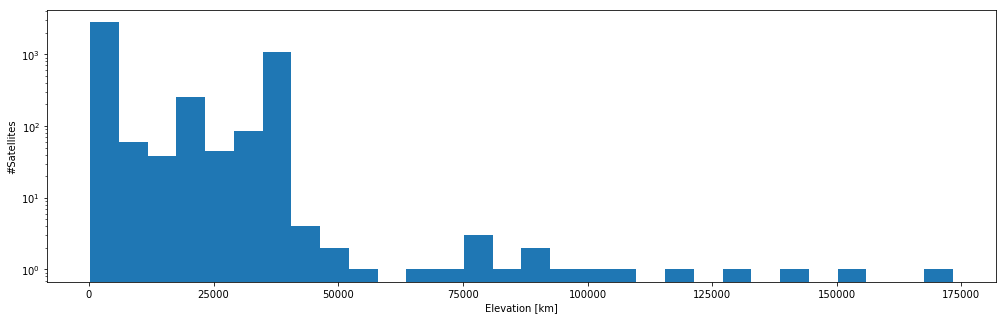

In [26]:
#no_deb["Elevation [km]"].astype("float").plot(kind="bar", bins= 30)
plt.hist(no_deb["Elevation [km]"].astype("float"), bins = 30, log=True)
plt.xlabel("Elevation [km]")
plt.ylabel("#Satellites")
plt.show()

We can observe two main peak. One close to representing satellites orbinting below ~4500 km and one for those orbiting around 35'000 km. Those two bar corresponds to the LEO(Low Earth Orbit) and the GEO/GSO(Geosynchronous/Geostationary orbit). In The middle there is still a lot of satellites, they are called the. The remaining satellites higher than the GEO/GSO are called HEO(High Earth Orbit).

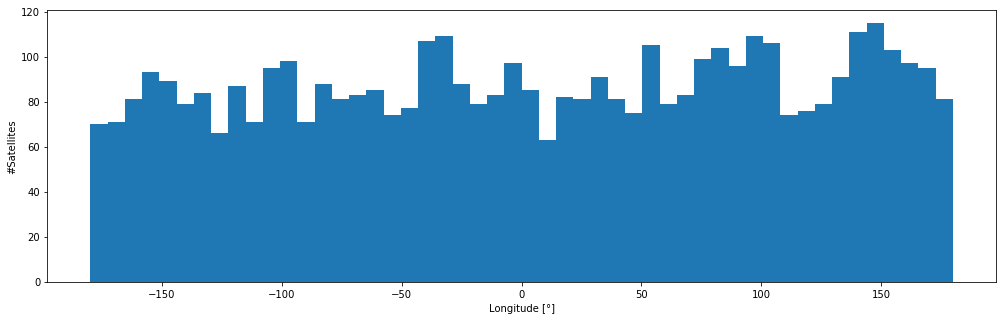

In [33]:
plt.hist(no_deb["Longitude [°]"].astype("float"), bins = 50, log=False)
plt.xlabel("Longitude [°]")
plt.ylabel("#Satellites")
plt.show()

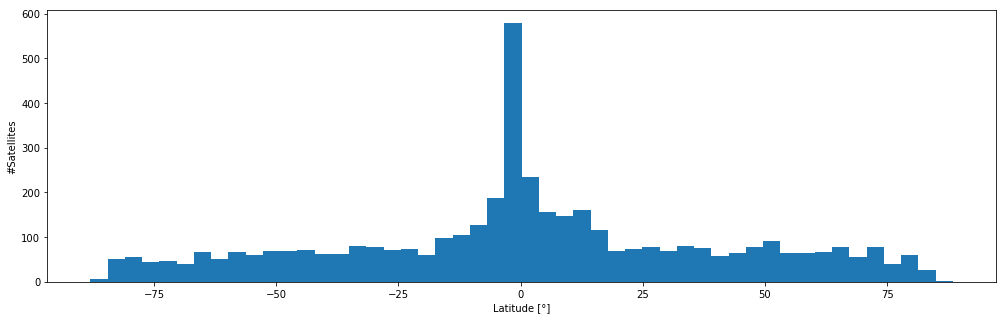

In [34]:
plt.hist(no_deb["Latitude [°]"].astype("float"), bins = 50, log=False)
plt.xlabel("Latitude [°]")
plt.ylabel("#Satellites")
plt.show()

As we can see the satellites a well spead along the whole range of longitude. However it's not the case for the latitudes. At least not for the latitude 0.
The latitude 0 corresponds to the ecuador. And this is where Geostationary satellites are located. Geostationary satellites have the same period as the one from the earth and always have the same positions relatively to the ground.

## 3.2 Satellites in Orbit Info

The second file that we retrieved contain aditional information for each satellites as we can see below

In [36]:
sioi = pd.read_csv("Dataset/satellites_in_orbit_info.csv")
sioi.head()

,OBJECT_ID,OBJECT_NAME,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS_SIZE,RCSVALUE,LAUNCH,COMMENT
0,2017-075D,CZ-2C R/B,43031,PRC,95.19,35.21,599.0,457.0,NaN,0,2017-11-24,NaN
1,2017-075C,YAOGAN-30 F,43030,PRC,96.62,35.00,604.0,590.0,NaN,0,2017-11-24,NaN
2,2017-075B,YAOGAN-30 E,43029,PRC,96.62,35.00,604.0,590.0,NaN,0,2017-11-24,NaN
3,2017-075A,YAOGAN-30 D,43028,PRC,96.62,35.00,603.0,590.0,NaN,0,2017-11-24,NaN
4,1998-067NL,OSIRIS-3U,43027,US,92.59,51.64,405.0,398.0,NaN,0,1998-11-20,NaN


We start by cleaning the dataframe before vizualizing it. We start by dropping the columns COMMENT, RCSVALUE and RCS_SIZE because the don't contains information most of the time

In [39]:
sioi = sioi.drop(["COMMENT", "RCSVALUE", "RCS_SIZE"], axis = 1)

We then remove the satellites that have duplicates and that have the DEB extension to be consistent with our previous processing on the tle file. We also remove row that still contains NaN values.

In [41]:
sioi = sioi[["DEB" not in x for x in sioi.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")
sioi = sioi.dropna(axis = 0)
sioi.head()

,OBJECT_ID,OBJECT_NAME,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,LAUNCH
0,2017-075D,CZ-2C R/B,43031,PRC,95.19,35.21,599.0,457.0,2017-11-24
1,2017-075C,YAOGAN-30 F,43030,PRC,96.62,35.00,604.0,590.0,2017-11-24
2,2017-075B,YAOGAN-30 E,43029,PRC,96.62,35.00,604.0,590.0,2017-11-24
3,2017-075A,YAOGAN-30 D,43028,PRC,96.62,35.00,603.0,590.0,2017-11-24
4,1998-067NL,OSIRIS-3U,43027,US,92.59,51.64,405.0,398.0,1998-11-20


We can now plot the apogee for example and we could expect a similar disctribution as the elevation feature for the TLE file.

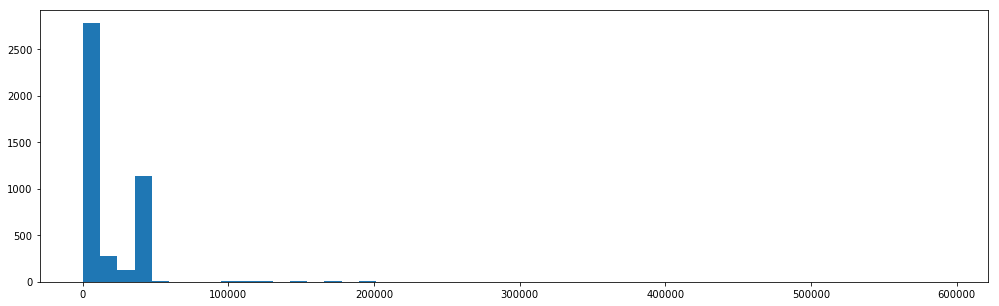

In [48]:
plt.hist(sioi.APOGEE, bins=50)
plt.show()

As we can see the two files don't seem to contains the same set of satellites. We can plot the satellites that have an apogee lower than 175'000 km to compare more precisely the two plots.

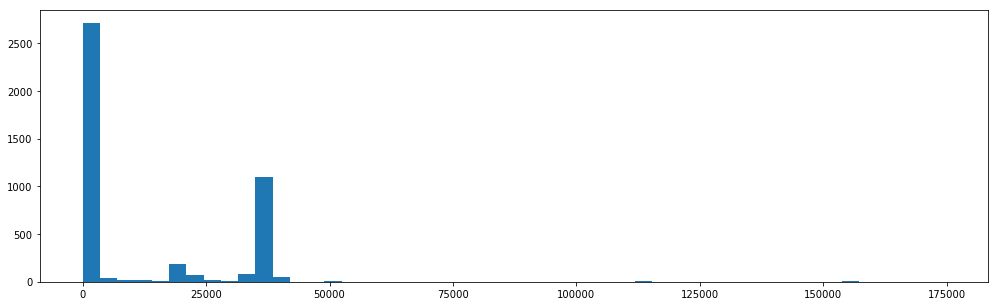

In [49]:
plt.hist(sioi.APOGEE[sioi.APOGEE < 175000], bins=50)
plt.show()

Apparently this file contains informations mainly about LEO and GEO/GSO satellites. In order to use both files in the exploitation we will merge them later.

We can plot the lauchdate histogram of this file

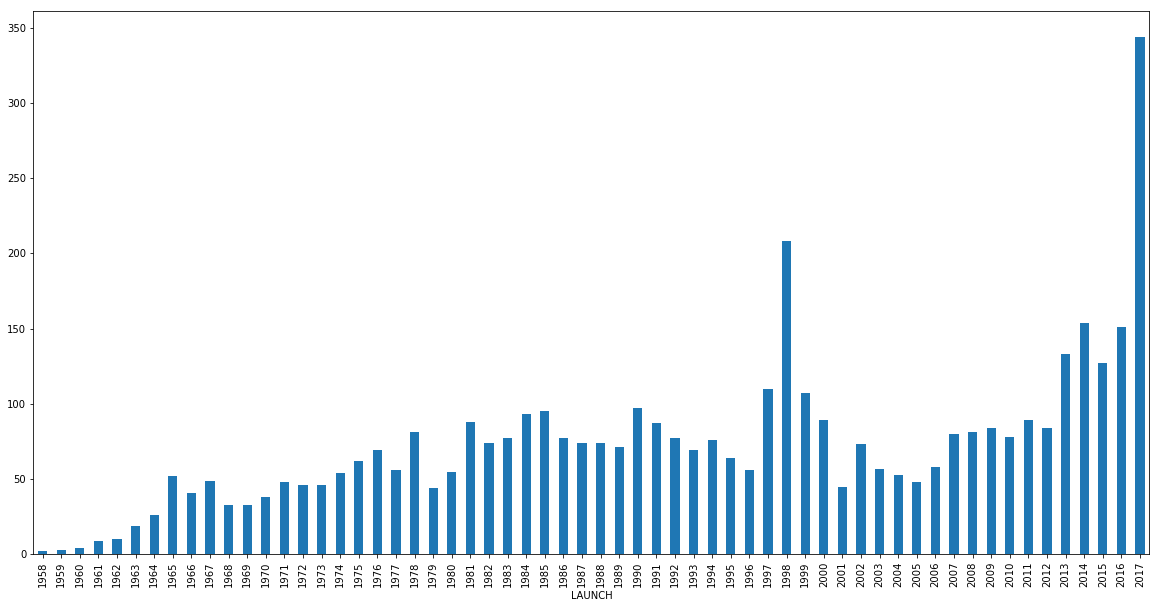

In [50]:
sioi["LAUNCH"]= pd.to_datetime(sioi["LAUNCH"]).apply(lambda x: x.strftime('%Y'))
sioi.groupby("LAUNCH").size().plot(kind="bar", figsize=(20,10))
plt.show()

There is clearly an increasing tendency throughout the years. The exponential behaviour in the latest year could be explained by the democratization of cube satellites lauch for commercial use.

## 3.3 Satellites Statistics per Country

The last file contains various statistics per country

In [53]:
sspc = pd.read_csv("Dataset/sat_statistics_per_country.csv")
sspc.head()

,COUNTRY,SPADOC_CD,ORBITAL_TBA,ORBITAL_PAYLOAD_COUNT,ORBITAL_ROCKET_BODY_COUNT,ORBITAL_DEBRIS_COUNT,ORBITAL_TOTAL_COUNT,DECAYED_PAYLOAD_COUNT,DECAYED_ROCKET_BODY_COUNT,DECAYED_DEBRIS_COUNT,DECAYED_TOTAL_COUNT,COUNTRY_TOTAL
0,ARAB SATELLITE COMMUNICATIONS ORGANIZATION,AB,0,13,0,0,13,1,0,0,1,14
1,ASIASAT CORP,AC,0,8,0,0,8,0,0,0,0,8
2,ALGERIA,ALG,0,5,0,0,5,0,0,0,0,5
3,ARGENTINA,ARGN,0,17,0,0,17,2,0,0,2,19
4,AUSTRIA,ASRA,0,3,0,0,3,0,0,0,0,3


This file will not be used in following analysis but for the sake of curiosity we can still plot the distribution of satellites per country

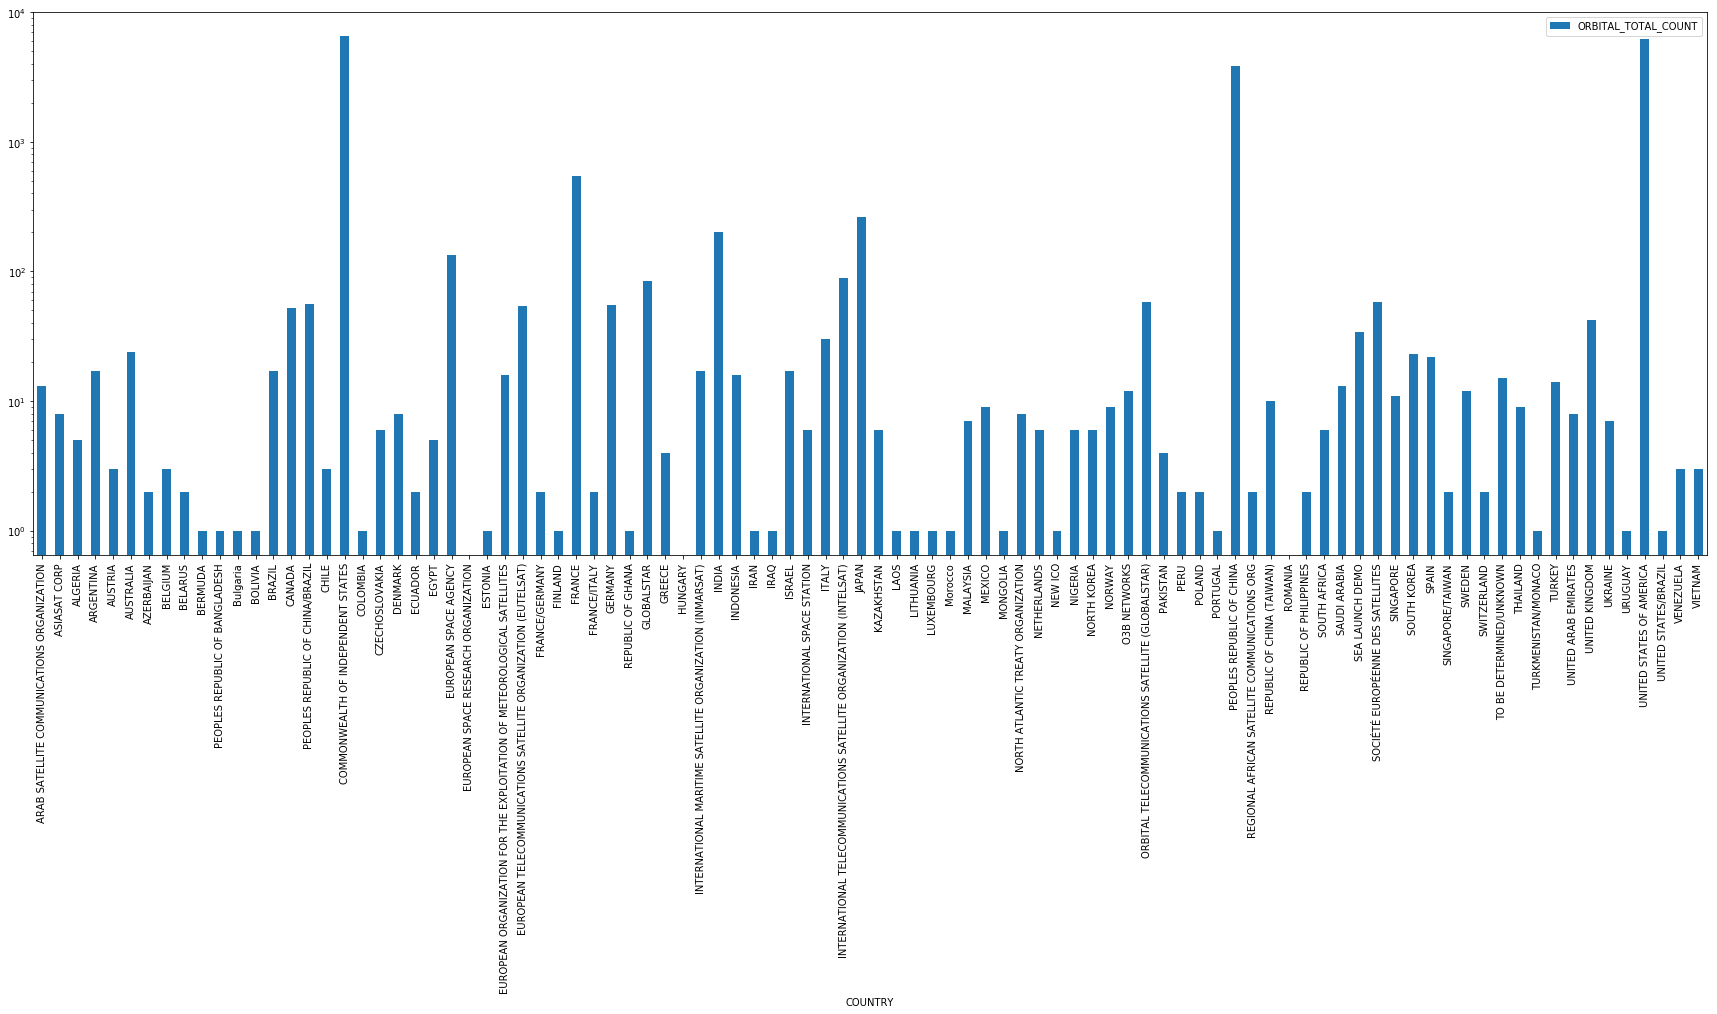

In [54]:
sspc = sspc[["COUNTRY", "ORBITAL_TOTAL_COUNT"]].set_index("COUNTRY")
sspc = sspc.drop("ALL")
sspc.plot(kind='bar', figsize = (30, 10), logy=True)
plt.show()

Not suprisingly the most active countries are the USA, China and Russia (more precisely Commonwealth of independant states)

# 4. Data Exploitation

We will combine the first two files from the exploratory part, namely the tle file and the Satellites in Orbit Info file. As we saw before they don't contains the same data. In order to use data present on both file we will merge both dataframe on their "Object_Name"

In [55]:
data_m = pd.merge(no_deb,sioi,how='inner', on="OBJECT_NAME")
data_m.head()

,OBJECT_NAME,Longitude [°],Latitude [°],Elevation [km],OBJECT_ID,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,LAUNCH
0,VANGUARD 1,-63.01315328238157,-26.65173623575367,950.1053125,1958-002B,5,US,132.75,34.24,3834.0,650.0,1958
1,VANGUARD 2,33.607191075144456,-32.25819456312109,2825.77825,1959-001A,11,US,121.47,32.87,2940.0,553.0,1959
2,VANGUARD R/B,158.90670062542114,1.4622271746404283,746.4226875,1958-002A,16,US,137.32,34.28,4223.0,655.0,1958
3,VANGUARD 3,-14.979412519707317,-30.811335100669776,3271.14,1959-007A,20,US,124.62,33.35,3263.0,510.0,1959
4,EXPLORER 7,165.9903034740197,9.845133707399345,517.82565625,1959-009A,22,US,96.36,50.28,683.0,486.0,1959


In [35]:
coord = list(zip(lat,long))
result = rg.search(coord)
countries = [temp['cc'] for temp in result]
data['Country'] = countries

In [18]:
data.head()

,OBJECT_NAME,Longitude [°],Latitude [°],Elevation [km],Country
0,VANGUARD 1,-63.01315328238157,-26.65173623575367,950.1053125,AR
1,VANGUARD 2,33.607191075144456,-32.25819456312109,2825.77825,ZA
2,VANGUARD R/B,158.90670062542114,1.4622271746404283,746.4226875,FM
3,VANGUARD R/B,-117.00344908625789,12.395302654786787,2056.953375,MX
4,VANGUARD 3,-14.979412519707317,-30.811335100669776,3271.14,SH


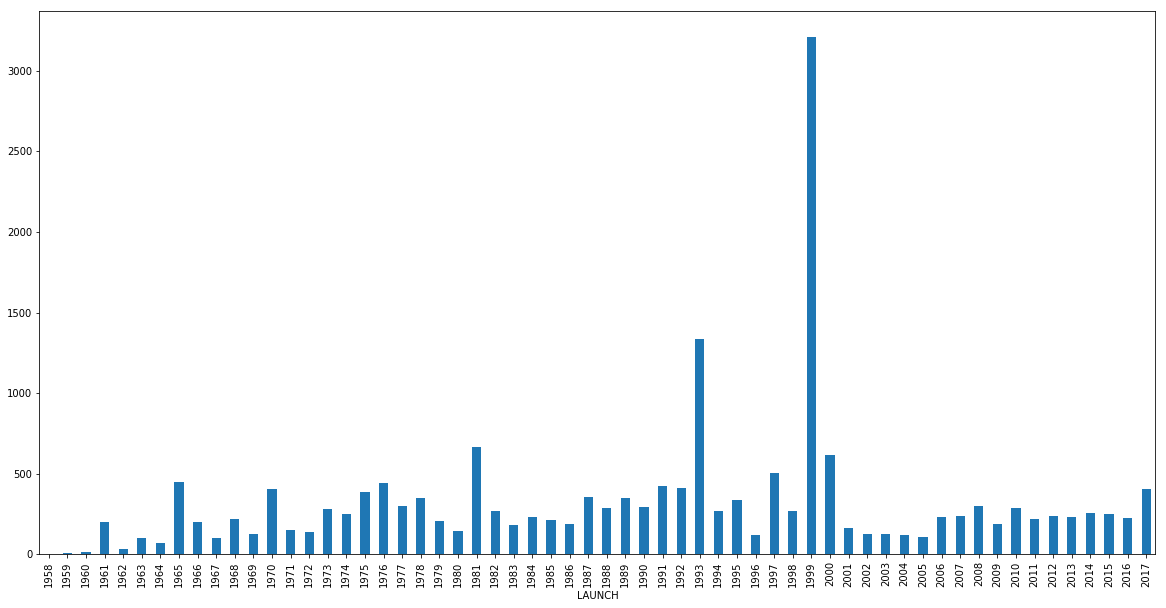

In [16]:
sioi = pd.read_csv("Dataset/satellites_in_orbit_info.csv")
sioi["LAUNCH"]= pd.to_datetime(sioi["LAUNCH"]).apply(lambda x: x.strftime('%Y'))
sioi.groupby("LAUNCH").size().plot(kind="bar", figsize=(20,10))
plt.show()